# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [406]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")
plt.style.use('ggplot')

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [407]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
dfo = df_offers
dfo.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [408]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
dft = df_transactions
dft.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [409]:
# Pivot dft table such that each offer_id gets its own column, aggregated by customer_name
dft2 = pd.pivot_table(dft, index='customer_name',columns='offer_id',aggfunc=np.sum).n
dft2 = dft2.fillna(0)
dft2.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [410]:
from sklearn.cluster import KMeans

In [411]:
# Create numpy matrix from dft
x_cols = np.matrix(dft2.values)

In [412]:
# Run clustering on x_cols for varying n_clusters
sss = []
ncs = range(1,11)
for nc in ncs:
    clust = KMeans(n_clusters=nc)
    clust.fit(x_cols)
    sss.append(clust.inertia_)

Text(0.5, 1.0, 'K-Means Elbow Graph')

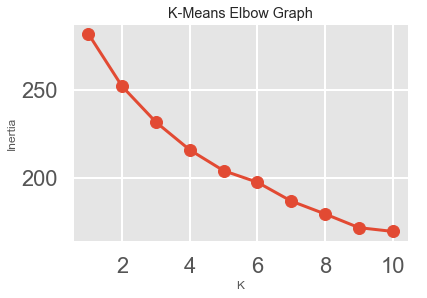

In [413]:
#Create K-Means Elbow graph
plt.plot(ncs,sss,marker='o')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('K-Means Elbow Graph')

<div class="span5 alert alert-success">
<p> The optimal K is not obvious from the plot above, as the curve is relatively smooth. In other words, there's no elbow in the graph. For now, let's chose K = 4 as optimal.
    </p>
</div>

In [447]:
# Using K=4, run kmeans model again.
kbest = 4
clust = KMeans(n_clusters=kbest)
clust.fit(x_cols)
kcounts = np.bincount(clust.labels_)

Text(0, 0.5, 'Number of points')

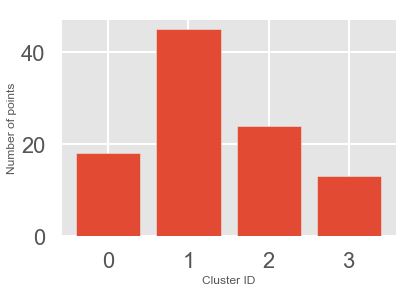

In [416]:
plt.bar(range(0,4),kcounts)
plt.xlabel("Cluster ID")
plt.ylabel("Number of points")

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [417]:
from sklearn.metrics import silhouette_score, silhouette_samples 
import matplotlib.cm as cm

For n_clusters = 2 The average silhouette_score is : 0.09365573283492713
For n_clusters = 3 The average silhouette_score is : 0.11889942863638556
For n_clusters = 4 The average silhouette_score is : 0.12347053919571699
For n_clusters = 5 The average silhouette_score is : 0.14092516241984757
For n_clusters = 6 The average silhouette_score is : 0.1371798939109807
For n_clusters = 7 The average silhouette_score is : 0.1161092456616906
For n_clusters = 8 The average silhouette_score is : 0.11339573832632867
For n_clusters = 9 The average silhouette_score is : 0.12505960527779877
For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


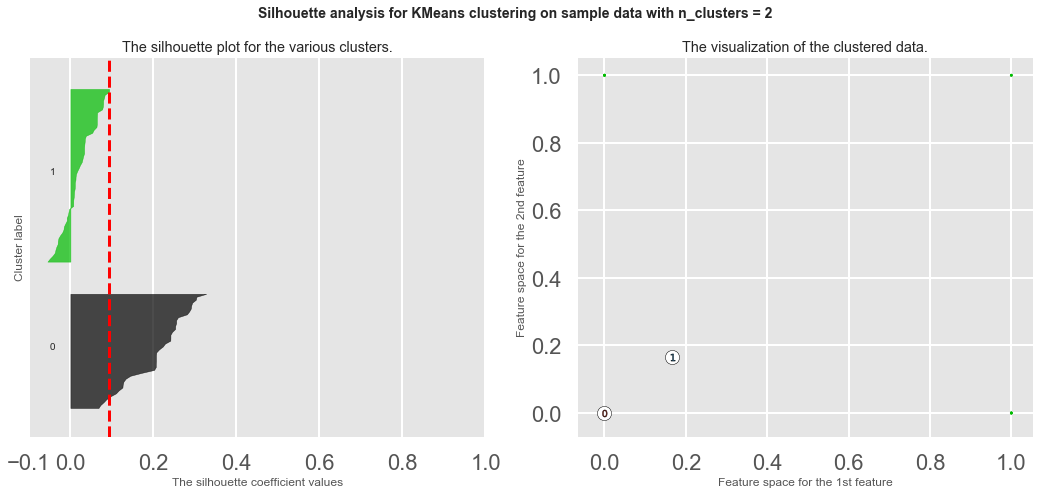

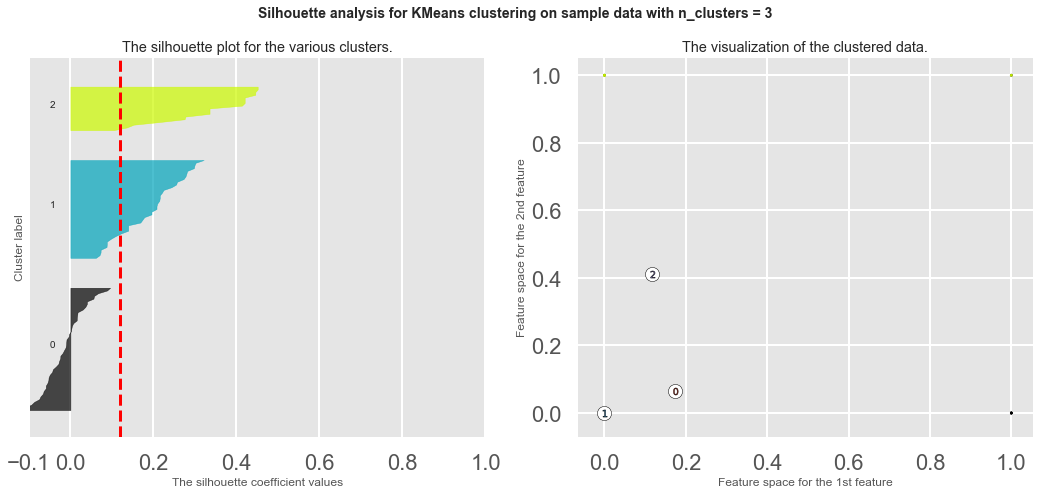

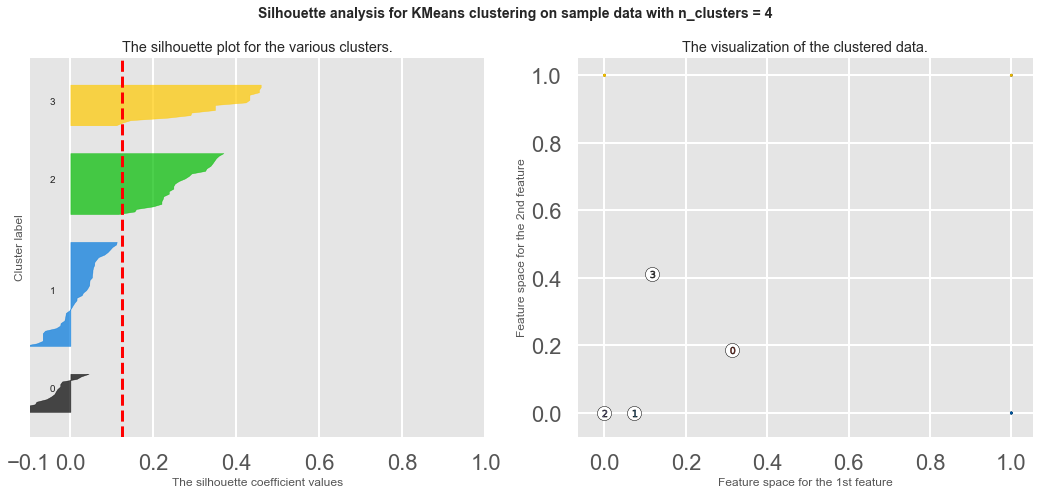

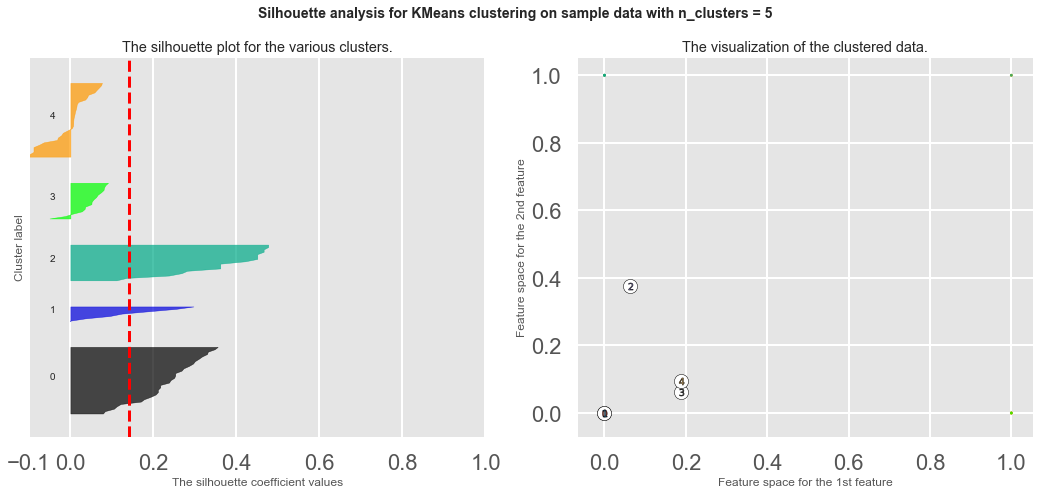

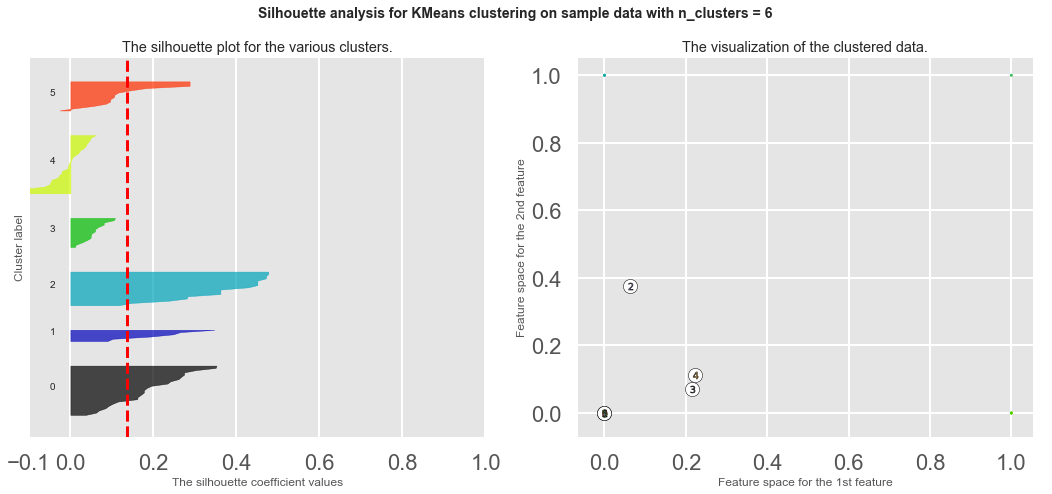

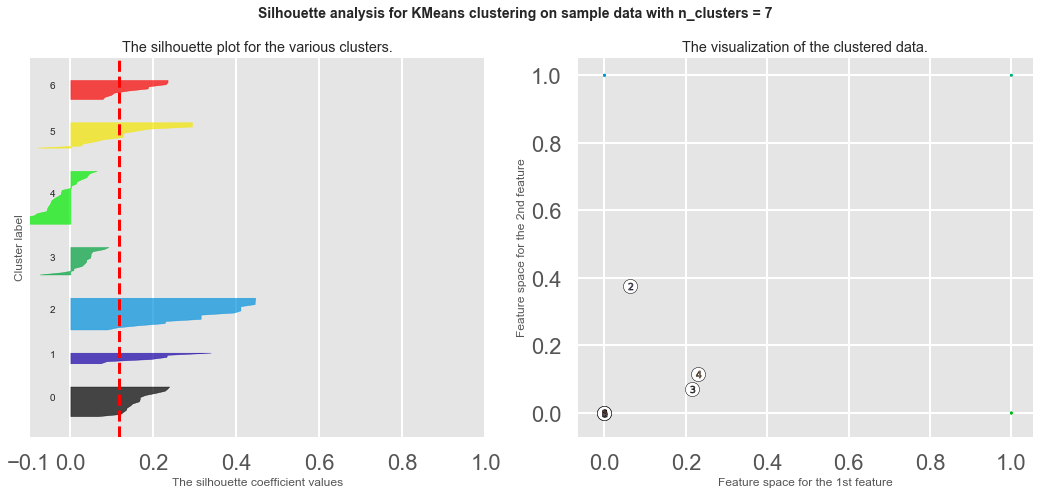

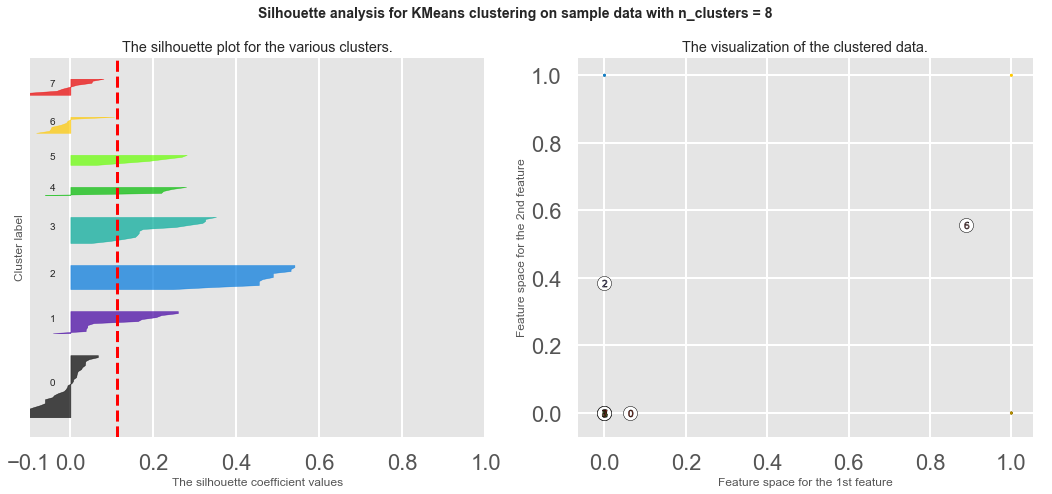

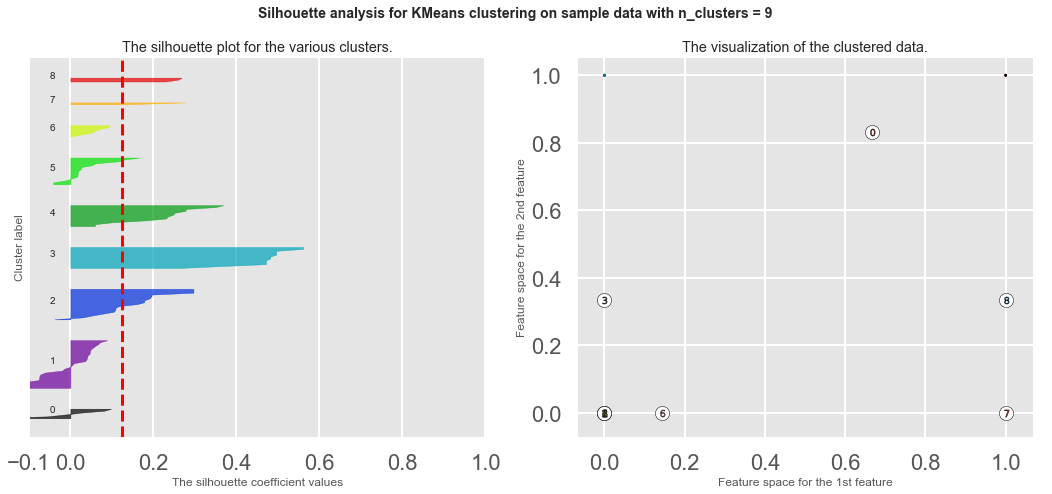

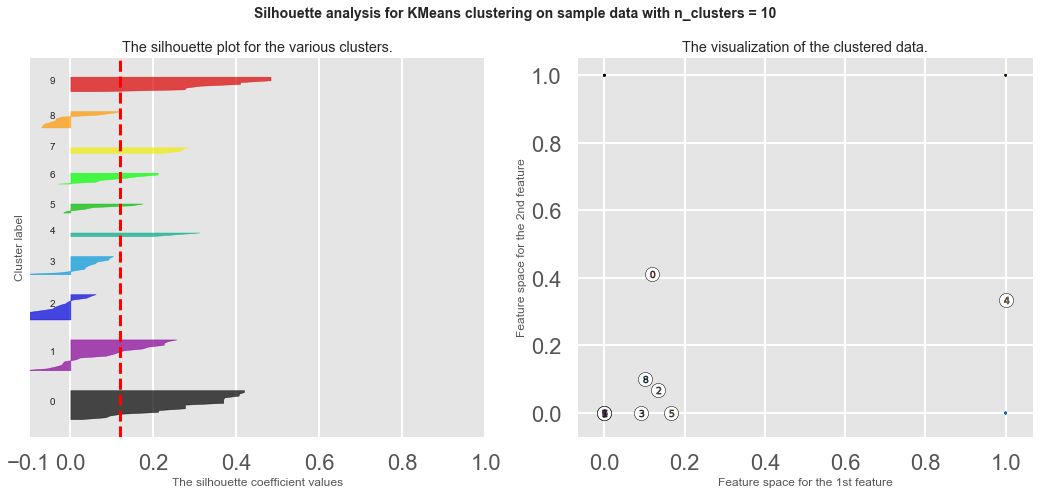

In [418]:
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]
X = x_cols
s_avgs = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    s_avgs.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(np.array(X[:, 0]), np.array(X[:, 1]), marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Text(0, 0.5, 'Average Silhouette Score')

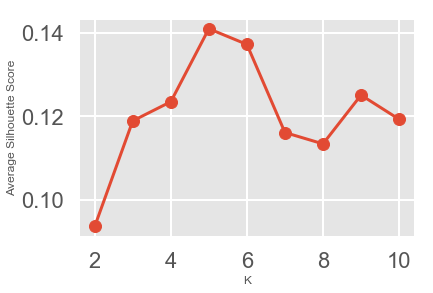

In [419]:
plt.plot(range_n_clusters,s_avgs,marker='o')
plt.xlabel('K')
plt.ylabel('Average Silhouette Score')

<div class="span5 alert alert-success">
<p> Here, we see the maximum average silhouette score is at K = 5, differing slightly from K = 4 from the elbow method. Since there was no obvious elbow in the previous method, it seems that K = 5 is likely a more reliable cluster number moving forward. 
    </p>
</div>

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [420]:
from sklearn.decomposition import PCA

In [421]:
def fit_clusters(X,n_clusters,dft2,xpca):
    """ Fit clustering model with n_clusters and return model with new dataframe"""
    mod = KMeans(n_clusters=n_clusters)
    mod.fit(X)
    preds = mod.predict(X)
    dft = pd.DataFrame({'Cluster':preds,'x':xpca[:,0],'y':xpca[:,1],'customer_name':dft2.index})
    sns.lmplot(x='x',y='y',data=dft,hue='Cluster',fit_reg=False)
    return mod, dft

In [422]:
#Do PCA with 2 dimensions
pca = PCA(n_components=2)
pca.fit(x_cols)
xpca = pca.transform(x_cols)

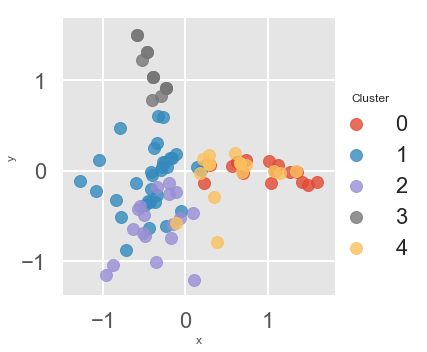

In [423]:
# Plot PCA with 5 clusters
mod5, dft5k = fit_clusters(x_cols,5,dft2,xpca)

In [424]:
dft5k.head()

,Cluster,x,y,customer_name
0,0,1.007580,0.108215,Adams
1,1,-0.287539,0.044715,Allen
2,3,-0.392032,1.038391,Anderson
3,0,0.699477,-0.022542,Bailey
4,2,0.088183,-0.471695,Baker


<div class="span5 alert alert-success">
<p> Based on the plot above, it looks like 5 clusters may be too many. The clusters on the top and the right look good, but the rest look quite mixed together. It looks like 3-4 clusters might describe the data better.  
    </p>
</div>

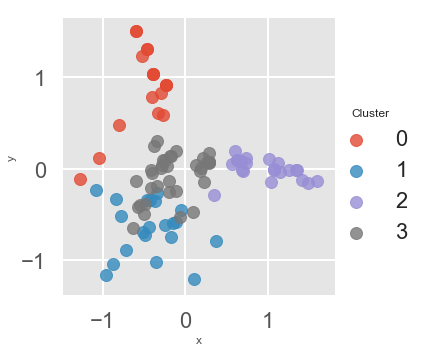

In [425]:
# Plot PCA with 4 clusters
mod4, dft4k = fit_clusters(x_cols,4,dft2,xpca)

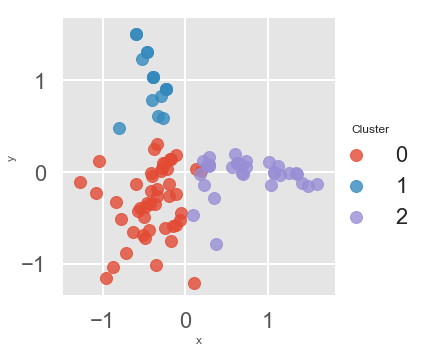

In [426]:
# Plot PCA with 3 clusters
mod3, dft3k = fit_clusters(x_cols,3,dft2,xpca)

<div class="span5 alert alert-success">
<p> Based on the plots above, K=3 shows the clearest non-overlapping clusters. This assumes, however, that 2 is the optimal number of dimensions for PCA.
    </p>
</div>

In [448]:
#Merge the clustered data with the original transaction data
dft3km = pd.merge(dft3k,dft,how='outer',on='customer_name').drop(['n'],axis=1)
#dft3km.head()

In [449]:
#Merge the new transaction table with the offers table
dfm = pd.merge(dft3km,dfo,how='outer',on='offer_id')
#dfm.head()

In [432]:
#Group the new merged table by Cluster and varietal, to get the min_qty for each cluster.
dfm2 = dfm.groupby(['Cluster','varietal'])['min_qty'].count().unstack('varietal').fillna(0)
dfm2

varietal,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
Cluster,,,,,,,,,
0,31.0,73.0,14.0,8.0,15.0,13.0,1.0,7.0,19.0
1,0.0,1.0,1.0,0.0,1.0,1.0,0.0,37.0,2.0
2,1.0,7.0,0.0,32.0,16.0,6.0,16.0,0.0,22.0


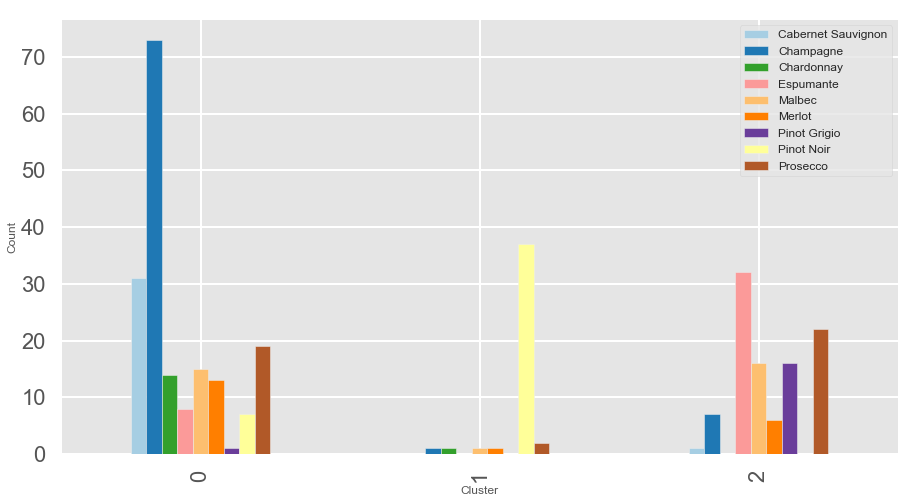

In [433]:
#Make a bar plot, showing the min_qty of each varietal for each cluster
dfm2.plot(kind='bar',figsize=(15,8),cmap = 'Paired')
plt.ylabel('Count')
plt.legend(fontsize=12)

varietal,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
Cluster,,,,,,,,,
0,0.0,0.0,0.0,12.0,12.0,4.0,10.0,0.0,17.0
1,23.0,35.0,12.0,2.0,11.0,11.0,0.0,10.0,10.0
2,8.0,39.0,3.0,4.0,5.0,3.0,1.0,1.0,13.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0
4,1.0,7.0,0.0,22.0,4.0,2.0,6.0,0.0,3.0


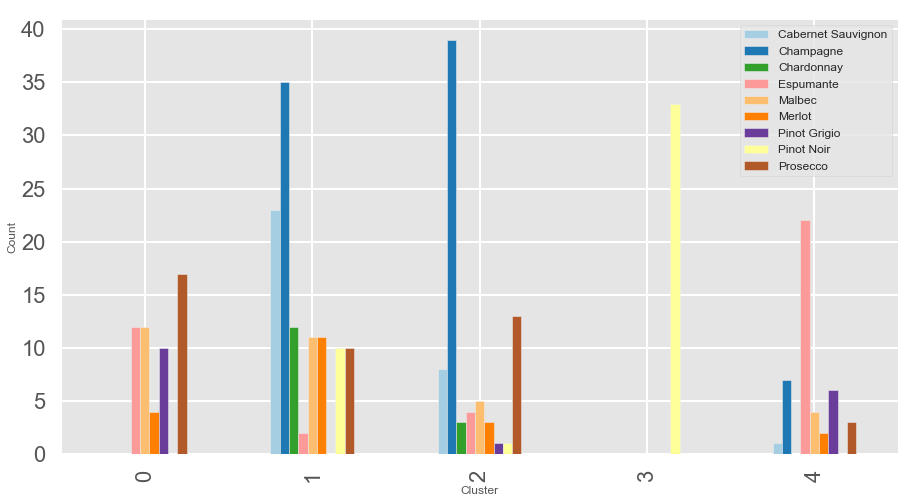

In [434]:
#Repeat the above plotting process for 5 clusters instead of 3.
dft5km = pd.merge(dft5k,dft,how='outer',on='customer_name').drop(['n'],axis=1)
dfm5 = pd.merge(dft5km,dfo,how='outer',on='offer_id')
dfm52 = dfm5.groupby(['Cluster','varietal'])['min_qty'].count().unstack('varietal').fillna(0)
dfm52.plot(kind='bar',figsize=(15,8),cmap = 'Paired')
plt.ylabel('Count')
plt.legend(fontsize=12)
dfm52

<div class="span5 alert alert-success">
<p> For comparison, the final analysis was done for K=3 and K=5. What's clear is that there is one group that has a strong preference for Pinot Noir (cluster 1 and 3 for K=3 and K=5, respectively). Furthermore, cluster 0 (K=3) and 1 (K=5) is roughly the same, with a clear preference for Champagne, as well as some interest in Cabernet Sauvignon. It seems clear that K=5 models the differences between the remaining clusters and thus moving forward we should go with K=5.

__Group 0__: Prosecco leads against Espumante, Malbec, and Pinot Grigio, but not by much.

__Group 1__: Champagne is at the top, with Cabernet Sauvignon a close second. Several wines hover in third place.

__Group 2__: Champagne is the clear winner, with Presecco in distant second and Cabernet Sauvignon in third. 

__Group 3__: Only interested in Pinot Noir

__Group 4__: Espumante is at the top, with slight interest in Champagne and Pino Grigio. 
    
   </p>
</div>

<div class="span5 alert alert-success">
<p> Below are the names for each of the top varietals in each cluster. It is only printing varietals whose min_qty is higher than the mean for that cluster. These varietal-name pairs are exactly what we'll need moving foward with a new offer/marketing campaign.
    
   </p>
</div>

In [460]:
#Average in each cluster
cmean = dfm52.mean(axis=1)
cmean

Cluster
0     6.111111
1    12.666667
2     8.555556
3     3.666667
4     5.000000
dtype: float64

In [465]:
#Display the names for each of the top varietals (greater than the mean) in each cluster.
for i in range(0,5):
    tmp=dfm52.iloc[i]>cmean[i]
    tmp2 = dfm52.iloc[i][tmp]
    
    print('Cluster',i)  
    for j in range(len(tmp2)):
        print('\033[1m' + tmp2.index[j] + '\033[0m') #,tmp2[j])
    print('\n')

Cluster 0
Espumante
Malbec
Pinot Grigio
Prosecco


Cluster 1
Cabernet Sauvignon
Champagne


Cluster 2
Champagne
Prosecco


Cluster 3
Pinot Noir


Cluster 4
Champagne
Espumante
Pinot Grigio




In [490]:
dfm53 = dfm5.sort_values(by=['Cluster'])#
dfnames = dfm53[['Cluster','customer_name']].sort_values(by=['Cluster']).drop_duplicates()
clustnum = 0
print('\033[1m' + 'Cluster '+ str(0) +'\033[0m')
for i in range(0,len(dfnames)):
    clusttmp = dfnames.iloc[i,0]
    if clusttmp > clustnum:
        clustnum = clusttmp
        print('\n')
        print('\033[1m' + 'Cluster '+ str(clustnum) +'\033[0m')
    #print(dfnames.iloc[i,0])
    print(dfnames.iloc[i,1])

Cluster 0
Adams
Lewis
Long
Diaz
Carter
Brown
Myers
Taylor
King
James
Cruz
Rivera
Hughes
Perez
Bailey
Watson
Robinson
Green
Murphy


Cluster 1
Sanchez
Davis
Cooper
Gomez
Sanders
Martinez
Gray
Howard
Lopez
Butler
Wright
Martin
Ward
Thomas
Lee
Thompson
Jackson
Peterson
Collins
White
Foster
Ramirez
Reyes
Allen
Evans
Russell
Powell
Richardson
Mitchell
Hall
Reed
Scott
Garcia


Cluster 2
Price
Morales
Turner
Nguyen
Parker
Barnes
Wood
Fisher
Young
Miller
Clark
Williams
Nelson
Baker
Harris
Gonzalez
Kelly
Roberts


Cluster 3
Jenkins
Cook
Campbell
Bell
Anderson
Smith
Johnson
Moore
Flores
Cox
Phillips
Morris
Rodriguez


Cluster 4
Ross
Hill
Gutierrez
Edwards
Brooks
Bennett
Rogers
Morgan
Stewart
Perry
Ortiz
Wilson
Walker
Hernandez
Sullivan
Torres
Jones


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

Text(0, 0.5, 'Explained Variance')

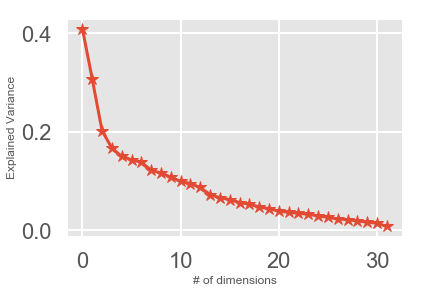

In [437]:
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = PCA()
pca.fit(x_cols)
expv = pca.explained_variance_
plt.plot(range(len(expv)),expv,marker='*')
plt.xlabel('# of dimensions')
plt.ylabel('Explained Variance')

<div class="span5 alert alert-success">
<p> Based on the plot above, the elbow point is around 3-4 dimensions. This would be the optimal number of dimensions to which to reduce the data.
    </p>
</div>

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### Affinity Propagation

In [438]:
from sklearn.cluster import AffinityPropagation as AP

In [451]:
def fit_model(model,**kwargs):
    mod = model(**kwargs)
    mod.fit(x_cols)
    labels = mod.labels_
    df = pd.DataFrame({'Cluster':labels,'x':xpca[:,0],'y':xpca[:,1],'customer_name':dft2.index})
    fig = plt.figure(figsize=(15,8))
    plt.scatter(df.x , df.y, c = df['Cluster'], cmap = 'rainbow')
    plt.colorbar()
    plt.show()
def fit_model3D(model,**kwargs):
    """Fit the data to input 'model', and create scatter plots using PCA with 3 dimensions. 
    Then, show a bar plot of the varietals for each cluster. """
    mod = model(**kwargs)
    mod.fit(x_cols)
    labels = mod.labels_
    pca3 = PCA(n_components=3)
    pca3.fit(x_cols)
    xpca3 = pca3.transform(x_cols)
    df = pd.DataFrame({'Cluster':labels,'x':xpca3[:,0],'y':xpca3[:,1],'z':xpca3[:,2],'customer_name':dft2.index})
    fig = plt.figure(figsize=(12,6))
    plt.scatter(df.x , df.y, c = df['Cluster'], cmap = 'rainbow')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    fig2 = plt.figure(figsize=(12,6))
    plt.scatter(df.x , df.z, c = df['Cluster'], cmap = 'rainbow')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.show()
    fig3 = plt.figure(figsize=(12,6))
    plt.scatter(df.y , df.z, c = df['Cluster'], cmap = 'rainbow')
    plt.colorbar()
    plt.xlabel('y')
    plt.ylabel('z')
    plt.show()
    dfttmp = pd.merge(df,dft,how='outer',on='customer_name').drop(['n'],axis=1)
    dfttmp2 = pd.merge(dfttmp,dfo,how='outer',on='offer_id')
    dfttmp3 = dfttmp2.groupby(['Cluster','varietal'])['min_qty'].count().unstack('varietal').fillna(0)
    dfttmp3.plot(kind='bar',figsize=(15,8),cmap = 'Paired')
    plt.ylabel('Count')
    plt.legend(fontsize=12)
    #dfm52

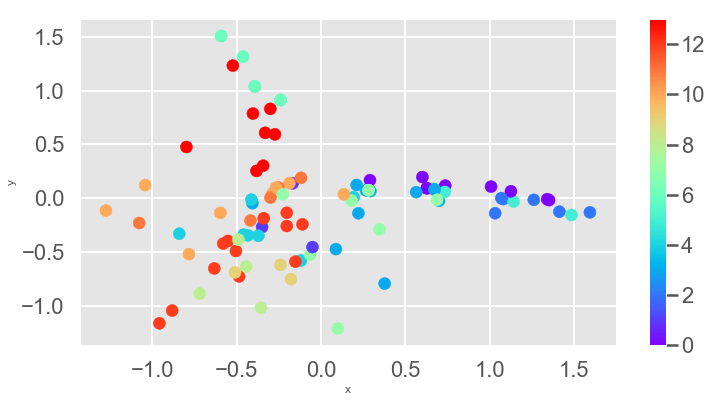

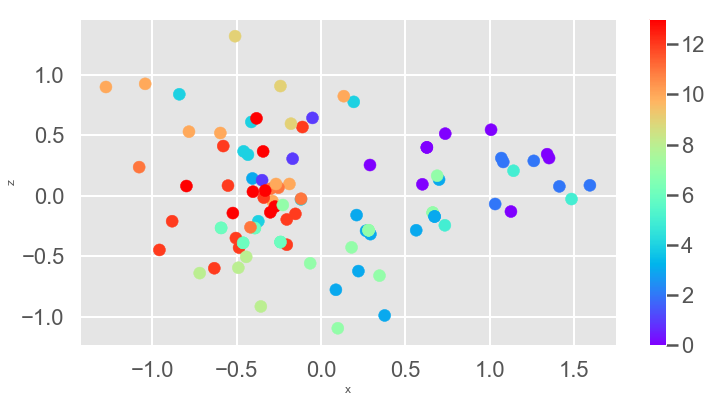

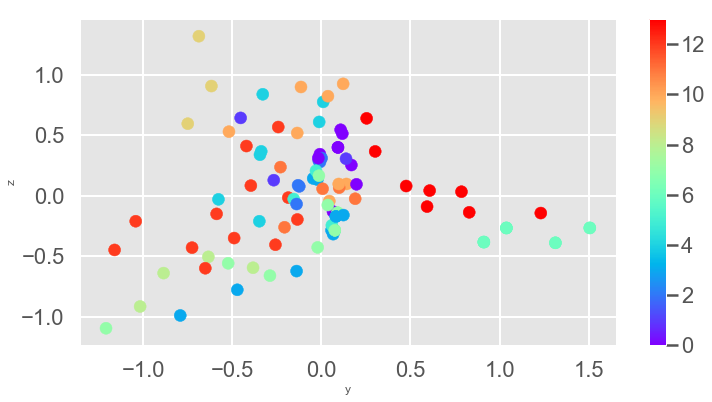

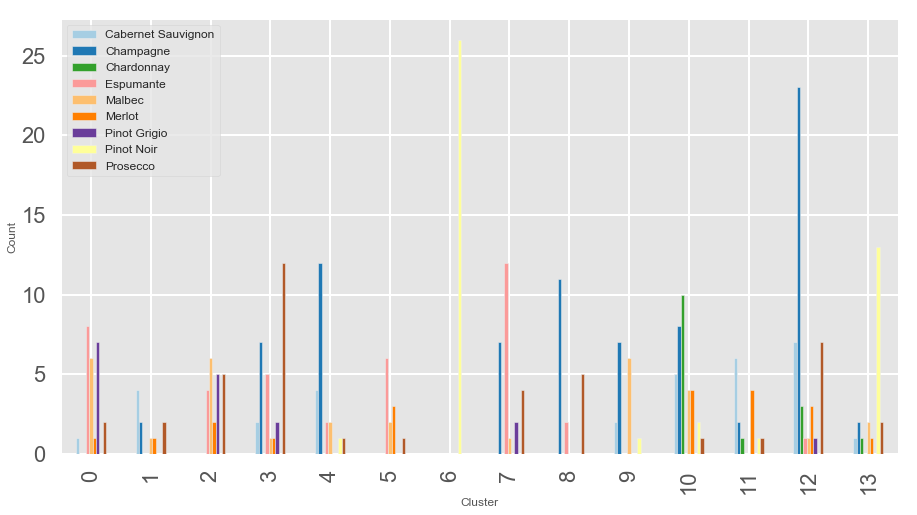

In [440]:
fit_model3D(AP)

### Spectral clustering

In [441]:
from sklearn.cluster import SpectralClustering as SC

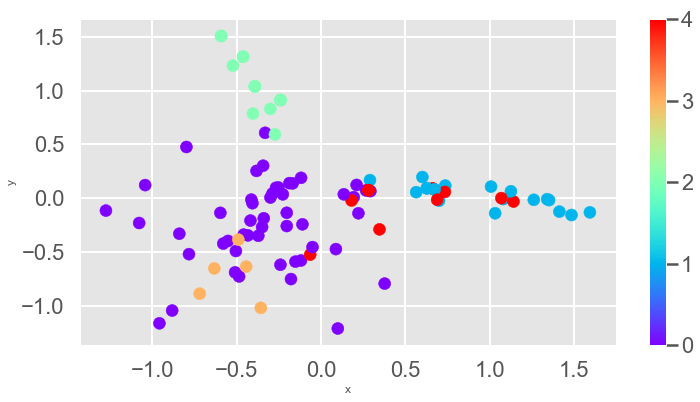

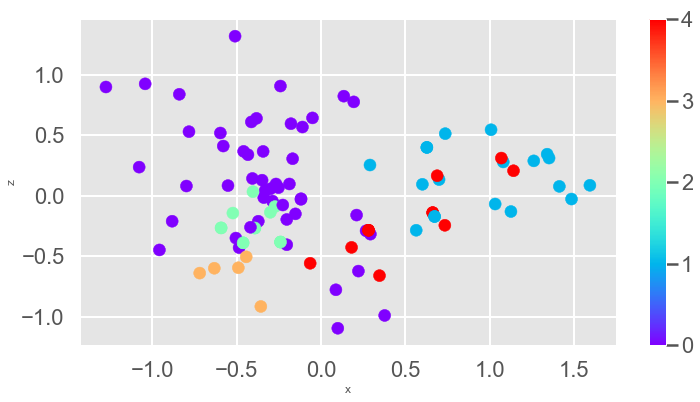

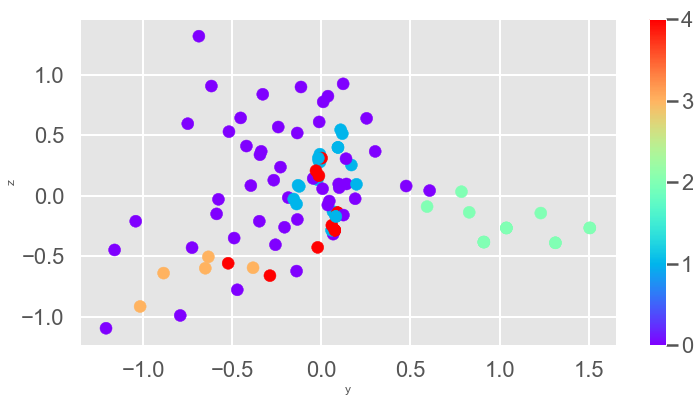

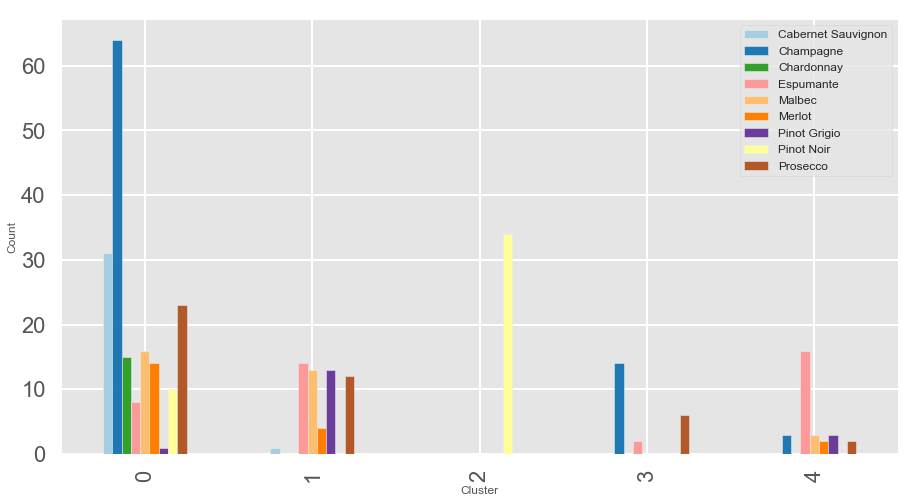

In [442]:
fit_model3D(SC,n_clusters=5)

### Agglomerative clustering

In [443]:
from sklearn.cluster import AgglomerativeClustering as AC

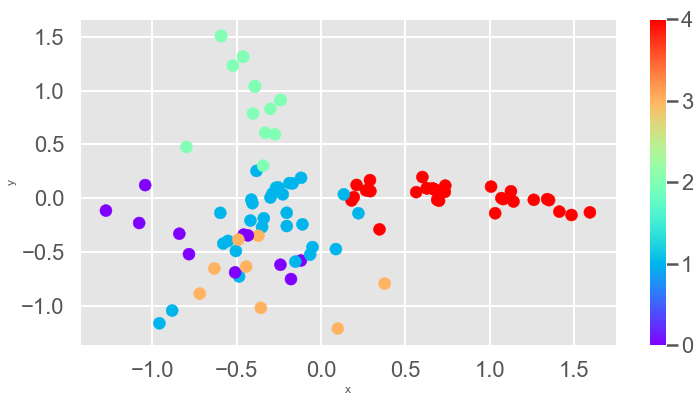

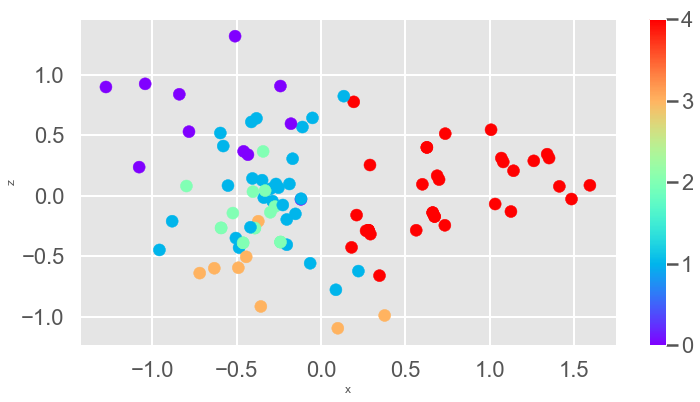

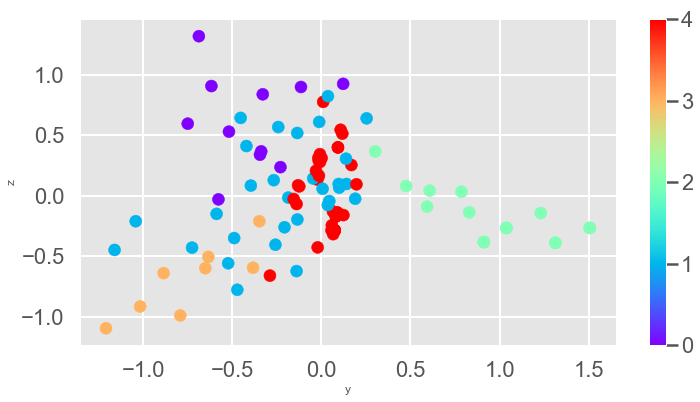

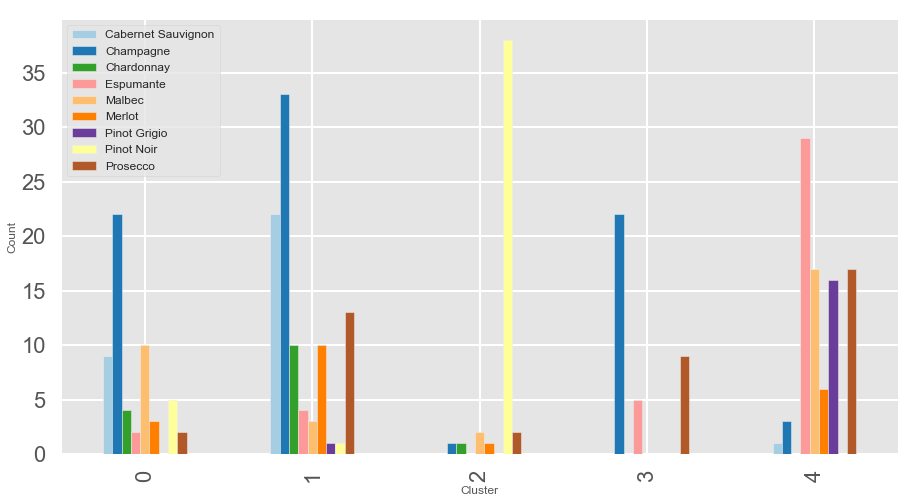

In [444]:
fit_model3D(AC,n_clusters=5)

### DBSCAN

In [445]:
from sklearn.cluster import DBSCAN

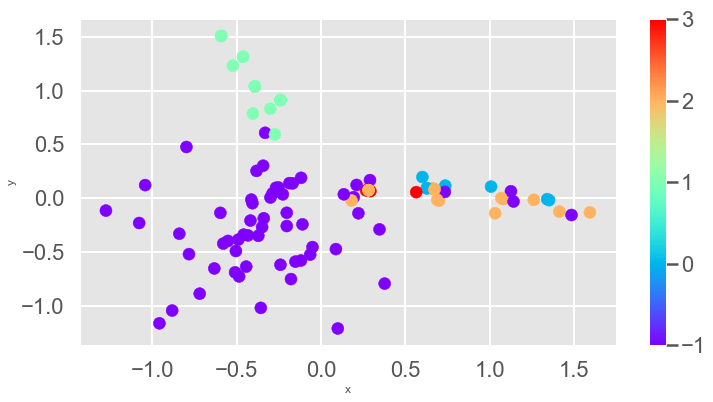

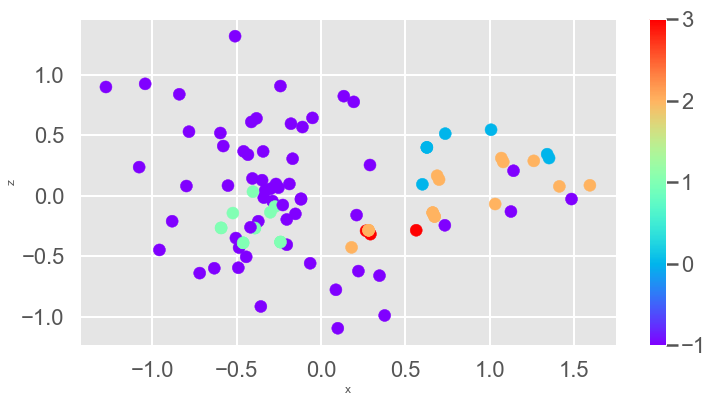

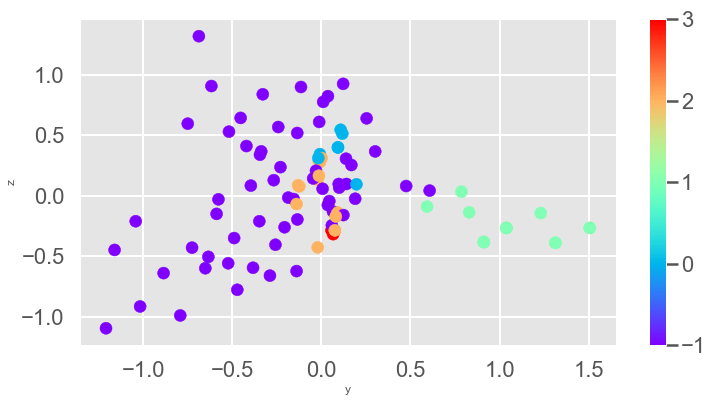

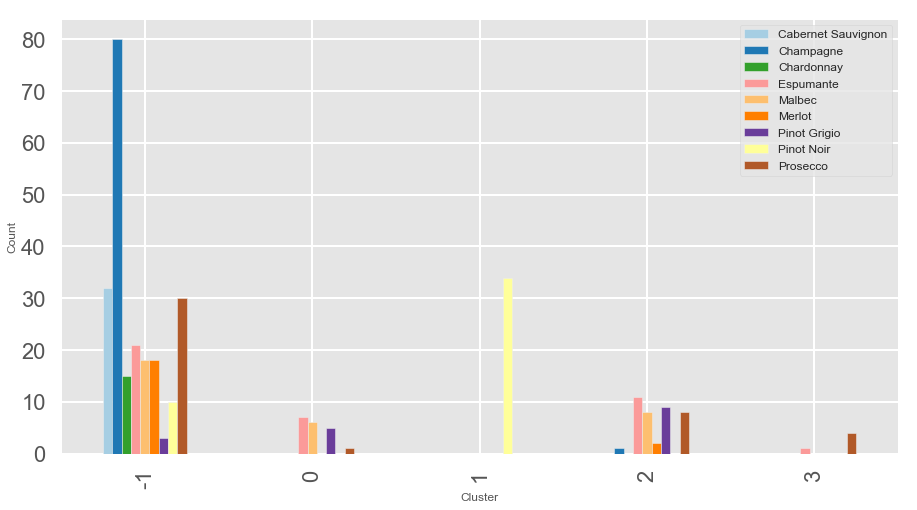

In [446]:
fit_model3D(DBSCAN,eps=1.2)

<div class="span5 alert alert-success">
<p> For all 4 of the above models, I used 3 dimensions in the PCA, since that what appeared to be ideal in the previous analysis. Then, to truly assess overlap of the data clusters, I made 3 scatter plots for each model: xy, xz, and yz. I then grouped and plotted by cluster similar to the previous KMeans analysis.
    
__AffinityPropogation__ seems to have created too many clusters. Some of them very clearly overlap in the scatter plots.

__SpectralClustering__ showed results that seem somewhat better than AffinityPropogation, although clusters 1 and 4 overlap significantly in the scatter plots. We could probably play around with n_clusters to optimize these results.

__AgglomerativeClustering__ showed clusters that are most distinct from each other (not overlapping). This model also showed results qualitatively similar to the KMeans analysis.

__DBSCAN__ had some overlapping clusters. It also had clusters with extremely low counts, grouping nearly all the names into clusters -1 and 1. 

__Overall__, AgglomerativeClustering is the most promising of the models tried, at least for this dataset.

   </p>
</div>